# Summary of this notebook

In the [last notebook](02_extract_images_and_data.ipynb), we exported the downloaded images as individual `.npy` files and the non-image data as a `.csv` file.  In this notebook, we examine the non-image data to make sure that no data are missing and that no other unexpected problems occurred.  We then explore the features in these data.

In [1]:
#If using Google Colab and Google Drive, run the following commands

#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#REPLACE THIS COMMAND WITH THE APPROPRIATE PATH TO THE "code" FOLDER ON YOUR GOOGLE DRIVE
#%cd ./drive/MyDrive/poverty_project/group_project/code

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from os.path import isfile, join

import geopandas
#pip install geos
#conda install geopandas

In [4]:
combined = pd.read_csv('../data/combined_dhs_data.csv', index_col='index')
combined.head()

,country,year,wealth_index,is_urban,households,latitude,longitude
index,,,,,,,
angola_2011_00-0,angola,2011.0,2.595618,1.0,36.0,-12.350257,13.534922
angola_2011_00-1,angola,2011.0,2.209620,1.0,32.0,-12.360865,13.551494
angola_2011_00-2,angola,2011.0,0.906469,1.0,36.0,-12.613421,13.413085
angola_2011_00-3,angola,2011.0,1.105359,1.0,35.0,-12.581454,13.397711
angola_2011_00-4,angola,2011.0,1.879344,1.0,37.0,-12.578135,13.418748


# Exploratory Data Analysis

### Countries

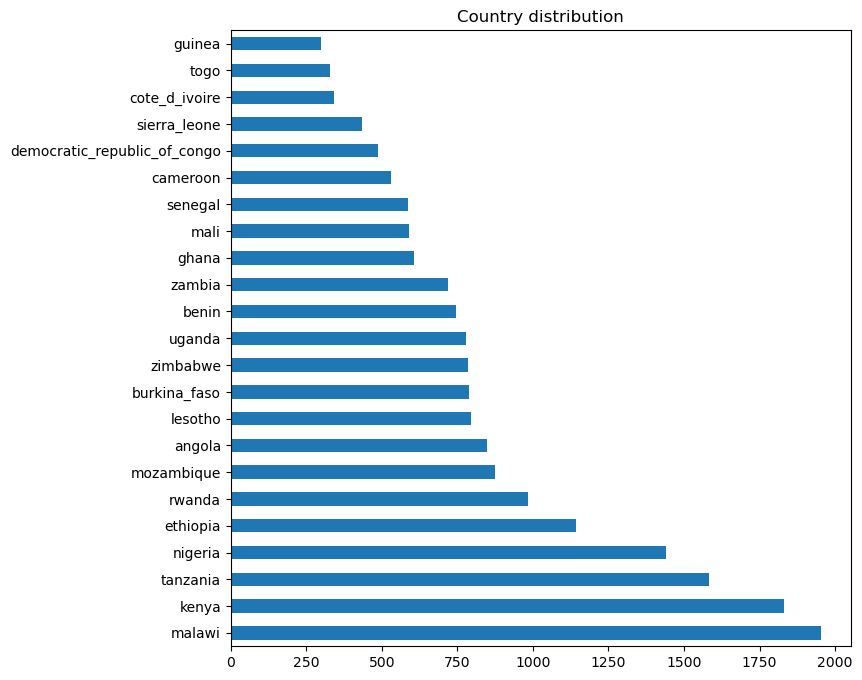

In [5]:
combined.country.value_counts().plot(kind='barh', title='Country distribution', figsize=(8,8));

### Years beginning the 3-year period of observation

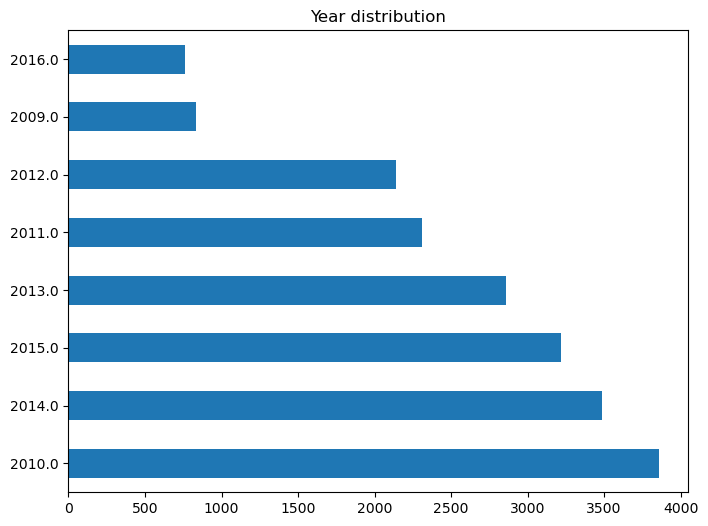

In [6]:
combined.year.value_counts().plot(kind='barh', title='Year distribution', figsize=(8,6));

Note that each of these "years" actually represents the beginning of the 3-year period over which the satellite images were constructed using median pixel values.

### Welath Indices

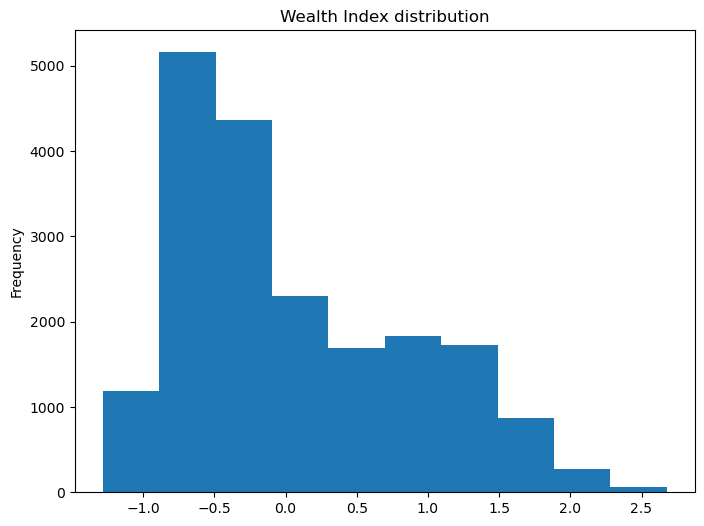

In [7]:
combined.wealth_index.plot(kind='hist', title='Wealth Index distribution', figsize=(8,6));

In [8]:
combined.wealth_index.describe()

count    19467.000000
mean         0.051598
std          0.806677
min         -1.282605
25%         -0.586443
50%         -0.207042
75%          0.666849
max          2.675832
Name: wealth_index, dtype: float64

In [9]:
combined.wealth_index.median()

-0.2070417255163192

So the wealth distribution is skewed to the right.  This is not surprising.

Urban vs. Non-Urban

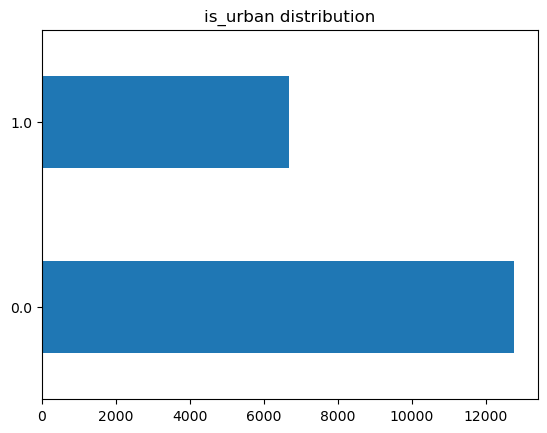

In [10]:
combined.is_urban.value_counts().plot(kind='barh', title='is_urban distribution');

### Households per Village

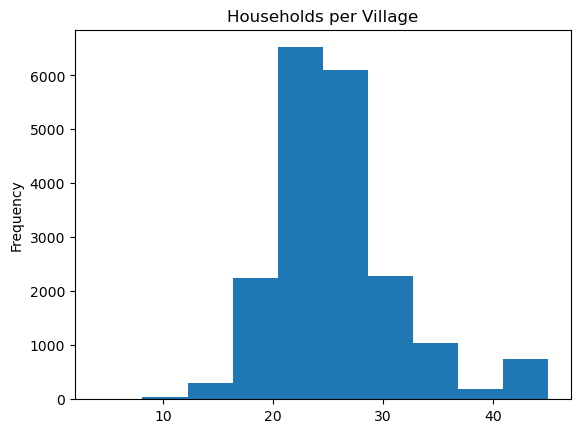

In [11]:
combined.households.plot(kind='hist', title = 'Households per Village');

### Geographic Coordinates

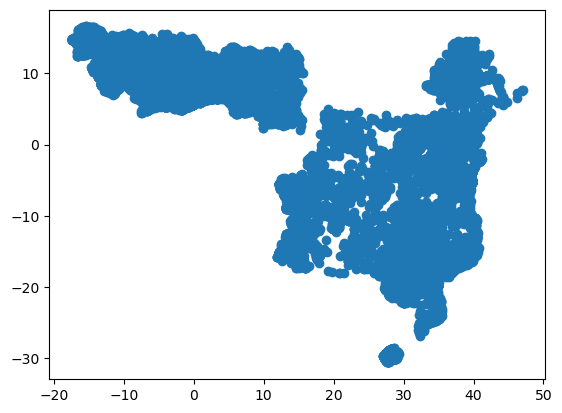

In [12]:
xs = combined['longitude']
ys = combined['latitude']

plt.scatter(xs,ys);

/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


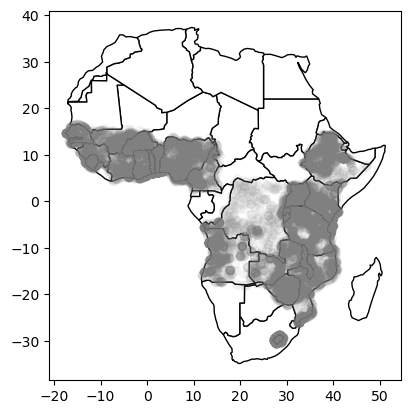

In [13]:
gdf = geopandas.GeoDataFrame(combined, geometry=geopandas.points_from_xy(combined.longitude, combined.latitude))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# We restrict to South America.
ax = world[world.continent == 'Africa'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='gray', alpha=0.05)

plt.show();
#https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html

### Rural/Urban Wealth index

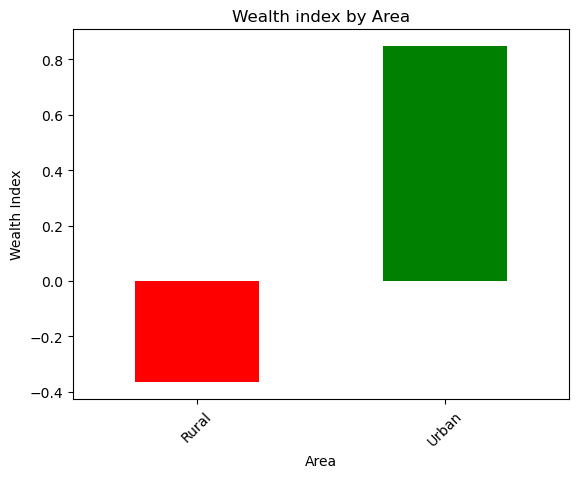

In [14]:
# Bar plot
combined.groupby(by=['is_urban']).mean()['wealth_index'].plot(kind='bar', color=['red', 'green']);
plt.title('Wealth index by Area')
plt.xlabel('Area')
plt.ylabel('Wealth Index')
plt.xticks([0, 1], ['Rural', 'Urban'], rotation=45);

/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


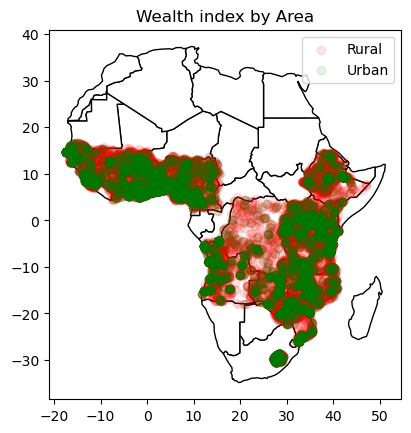

In [15]:
# Coordinates plot
gdf = geopandas.GeoDataFrame(combined, geometry=geopandas.points_from_xy(combined.longitude, combined.latitude))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# We restrict to South America.
ax = world[world.continent == 'Africa'].plot(
    color='white', edgecolor='black')

# Plot all to red
gdf.plot(ax=ax, color='red', alpha=0.1)

# Then plot Urban area to green
gdf = geopandas.GeoDataFrame(combined[combined['is_urban']==1], geometry=geopandas.points_from_xy(combined[combined['is_urban']==1].longitude, combined[combined['is_urban']==1].latitude))
gdf.plot(ax=ax, color='green', alpha=0.1)
plt.title('Wealth index by Area')
plt.legend(['Rural', 'Urban'])
plt.show();